# Regresión Logística

En éste notebook desarrollaremos e implementaremos el algoritmo de regresión logística, usando el conjunto de datos *Medical Insurance Cost Prediction*.
___

In [1]:
import pandas as pd
import numpy as np
import scipy.optimize as op
import math
import matplotlib.pyplot as plt

## Análisis de los datos

El conjunto de datos está enfocado a la predicción del coste del seguro médico, y nos brinda 54 características con las que operar.

[En ésta página web](https://www.kaggle.com/datasets/mohankrishnathalla/medical-insurance-cost-prediction/data) podremos ver en profundidad qué representan las distintas características.

En resumen, éstas pueden condensarse en 6 grupos:

1. Demográficas y Socioeconómicas.
2. Estilo de vida y hábitos.
3. Salud y datos clínicos.
4. Uso del seguro médico y procedimientos utilizados.
5. Seguro y Políticas.
6. Costes médicos y pagos.

La mayoría de características son numéricas,

Carguemos los datos y echémosles un vistazo:

In [2]:
data = pd.read_csv('./medical_insurance.csv')
data.head()

,person_id,age,sex,region,urban_rural,income,education,marital_status,employment_status,household_size,...,liver_disease,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure
0,75722,52,Female,North,Suburban,22700.0,Doctorate,Married,Retired,3,...,0,1,0,1,0,2,0,1,0,0
1,80185,79,Female,North,Urban,12800.0,No HS,Married,Employed,3,...,0,1,1,0,0,1,0,1,1,0
2,19865,68,Male,North,Rural,40700.0,HS,Married,Retired,5,...,0,0,1,1,0,2,1,0,1,0
3,76700,15,Male,North,Suburban,15600.0,Some College,Married,Self-employed,5,...,0,0,0,1,0,0,1,0,0,0
4,92992,53,Male,Central,Suburban,89600.0,Doctorate,Married,Self-employed,2,...,0,1,0,2,0,1,1,0,1,0


___
### Incongruencias y/o valores problemáticos
Antes de operar con el conjunto de datos, debemos hacer un análisis del mismo, en busca de datos problemáticos que puedan afectar a la calidad de nuestros modelos.

#### Edad (18 a 90 años)
Con una simple comprobación, podemos ver cómo existen valores fuera de la franja de edad establecida.

Menores de 18:

In [3]:
dataAux = data[data.age < 18] # Usaremos ésta variable datosAux para comprobaciones, no para operar
dataAux.head()

,person_id,age,sex,region,urban_rural,income,education,marital_status,employment_status,household_size,...,liver_disease,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure
3,76700,15,Male,North,Suburban,15600.0,Some College,Married,Self-employed,5,...,0,0,0,1,0,0,1,0,0,0
59,576,12,Male,Central,Suburban,52500.0,Masters,Divorced,Employed,2,...,0,0,0,0,0,1,0,0,0,0
89,30713,10,Female,South,Urban,69000.0,Some College,Single,Employed,3,...,0,0,0,1,0,0,1,1,0,0
159,13800,6,Female,West,Suburban,57600.0,Some College,Married,Self-employed,2,...,0,0,0,1,0,0,1,0,0,0
167,3232,15,Male,West,Suburban,48200.0,Bachelors,Single,Retired,3,...,0,0,0,1,0,1,0,1,0,0


Mayores de 90:

In [4]:
dataAux = data[data.age > 90]
dataAux.head()

,person_id,age,sex,region,urban_rural,income,education,marital_status,employment_status,household_size,...,liver_disease,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure
266,42222,91,Female,East,Suburban,32700.0,No HS,Married,Employed,3,...,0,0,0,1,0,1,0,1,1,0
355,33076,96,Female,East,Suburban,78900.0,HS,Married,Unemployed,4,...,0,0,1,0,0,0,2,1,1,1
651,65644,93,Male,East,Suburban,64100.0,Masters,Widowed,Employed,3,...,0,0,1,0,0,0,2,1,1,0
786,8312,91,Female,South,Suburban,209700.0,Bachelors,Single,Retired,2,...,0,1,0,0,0,0,0,0,1,0
845,67703,91,Male,North,Urban,11000.0,Bachelors,Married,Self-employed,2,...,0,0,0,0,0,2,0,1,1,0


En un principio, **para aquellos pacientes de más de 90 años, no tendríamos mayor problema**, simplemente se han salido del rango.

Sin embargo, **para aquellos pacientes menores a 18 años, las incongruencias son evidentes**: Algunos están supuestamente casados o divorciados y hasta empleados o retirados.

Por tanto, **debemos sanear éstos datos** en caso de que queramos usarlos. Para ello, tendríamos **diferentes métodos**:
1. **Elevar la edad hasta el mínimo de 18 años**: Es la vía más fácil, pero en muchos casos seguiría siendo insuficiente para mantener consistencia en los datos.
2. **Sustituir la edad de éstos pacientes a la media o mediana de todos los pacientes**: Permite una aproximación más cercana a la realidad que el método anterior, pero seguiría habiendo casos incongruentes. Por ejemplo, si la media o mediana fuesen 35 años, habría pacientes retirados a esa edad.
3. **Sustituir la edad de éstos pacientes por la media o mediana del resto de pacientes con el mismo estado civil y/o laboral**: Ésto permite una mejor aproximación a la realidad, ya que estaríamos aproximando las edades en base a los datos de pacientes parecidos. Con éste método, nos aseguramos tener muchas menos incongruencias que con los métodos anteriores.
4. **Sustituir en base a otras características comunes**: Lo mismo que el punto anterior, pero cambiando de características

Vamos a usar el tercer método con el estado civil para sanear éstos problemas:


In [24]:
unique_marital_status = data.marital_status.unique()
status_avg = {};
for status in unique_marital_status:
    status_avg[status] = data[data.marital_status == status ].age.min()
    print("Promedio de", status, ":",status_avg[status])
print(unique_marital_status)
print("Promedio:", status_avg['Married'])

Promedio de Married : 0
Promedio de Single : 0
Promedio de Divorced : 0
Promedio de Widowed : 0
['Married' 'Single' 'Divorced' 'Widowed']
Promedio: 0


___
#### Paciente de alto riesgo y puntuación de riesgo
Las características "Paciente de alto riesgo" (*is_high_risk*) y "Puntuación de riesgo" (*risk_score*) están estrechamente relacionadas.

La primera, *is_high_risk*, indica de forma binaria con un 1 si el paciente es de alto riesgo, y con un 0 el caso contrario.
La segunda, *risk_score*, indica la puntuación (normalizada) de un paciente de ser de alto riesgo. Al estar normalizada, podemos interpretar dicha columna como "la probabilidad de que el paciente sea o pase a ser de alto riesgo".

Por tanto, podríamos pensar que no tiene sentido que un paciente tenga un 100% de probabilidades de ser de alto riesgo y que aún no lo sea.

Echémos un vistazo:

In [6]:
dataAux = data.loc[(data.is_high_risk == 0) & (data.risk_score == 1)]
dataAux.head()

,person_id,age,sex,region,urban_rural,income,education,marital_status,employment_status,household_size,...,liver_disease,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure


Por tanto, podemos estar tranquilos: No hay paciente que haya sacado el máximo *risk_score* que no se haya catalogado como *is_high_risk = 1*.

___
### Comprobación general
#### Valores nulos

Miremos que no existen valores nulos ni NaN dentro del dataset:

In [7]:
colNames = data.columns
colsNullNaN = []
print(colNames)
for col in colNames:
    if data[col].isnull().values.any():
        colsNullNaN.append(col)

print('Columnas con valores nulos o NaN:', colsNullNaN)

Index(['person_id', 'age', 'sex', 'region', 'urban_rural', 'income',
       'education', 'marital_status', 'employment_status', 'household_size',
       'dependents', 'bmi', 'smoker', 'alcohol_freq', 'visits_last_year',
       'hospitalizations_last_3yrs', 'days_hospitalized_last_3yrs',
       'medication_count', 'systolic_bp', 'diastolic_bp', 'ldl', 'hba1c',
       'plan_type', 'network_tier', 'deductible', 'copay', 'policy_term_years',
       'policy_changes_last_2yrs', 'provider_quality', 'risk_score',
       'annual_medical_cost', 'annual_premium', 'monthly_premium',
       'claims_count', 'avg_claim_amount', 'total_claims_paid',
       'chronic_count', 'hypertension', 'diabetes', 'asthma', 'copd',
       'cardiovascular_disease', 'cancer_history', 'kidney_disease',
       'liver_disease', 'arthritis', 'mental_health', 'proc_imaging_count',
       'proc_surgery_count', 'proc_physio_count', 'proc_consult_count',
       'proc_lab_count', 'is_high_risk', 'had_major_procedure'],
      

In [8]:
dataAux = data[data['alcohol_freq'].isnull()]
dataAux.head()

,person_id,age,sex,region,urban_rural,income,education,marital_status,employment_status,household_size,...,liver_disease,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure
0,75722,52,Female,North,Suburban,22700.0,Doctorate,Married,Retired,3,...,0,1,0,1,0,2,0,1,0,0
2,19865,68,Male,North,Rural,40700.0,HS,Married,Retired,5,...,0,0,1,1,0,2,1,0,1,0
3,76700,15,Male,North,Suburban,15600.0,Some College,Married,Self-employed,5,...,0,0,0,1,0,0,1,0,0,0
8,60768,53,Male,North,Suburban,60700.0,No HS,Divorced,Retired,1,...,0,0,0,0,0,1,0,1,1,0
19,69162,53,Male,Central,Urban,41300.0,Bachelors,Single,Self-employed,2,...,0,1,0,0,0,0,0,0,1,0


Como hemos podido comprobar, en la columna de frecuencia de uso de alcohol *alcohol_freq* hay valores nulos.

Por tanto, **éstos valores han de ser saneados si se pretenden usar**. Las **opciones de saneamiento** que tenemos son prácticamente las mismas que en las edades:
- **Establecer un valor concreto que sustituirá a los nulos**: Podríamos decir que, allá donde encontremos un nulo, significará que el paciente no bebe, que lo hace ocasionalmente, semanalmente, etc.
- **Coger el valor más común y sustituirlo en los nulos**: Cambiariamos nulos por la opción más común. Es cierto que nos aproximaríamos más a la realidad, pero seguiremos careciendo de rigor.
- **Coger el valor más común dentro del grupo de "vecinos" y sustituirlo en los nulos**: Cambiaríamos nulos por la opción más común dentro de un grupo de pacientes parecido. Ésto nos permitiría ser más rigurosos, ya que tendríamos en cuenta distintos factores por el cual sustituiríamos el valor nulo. Una opción sería hacer grupos por edad, estado civil, sexo y estudios, por ejemplo.

___
#### Normalización y estandarización

Para empezar, las columnas a normalizar serán aquellas que no se pretendan predecir. Es decir, si estoy intentando predecir el coste anual del seguro médico, no voy a normalizar dicha columna; en cambio, si estoy usando el coste anual para predecir otra cosa, ahí si consideraré su normalización.

Por lo general, deberíamos de normalizar todos los campos numéricos para mantener una magnitud similar, sobretodo en aquellos campos donde las magnitudes sean especialmente dispares.

Sin embargo, hay casos donde podría no ser la mejor opción:
- *Campos "Binarios"*: Aquellos campos cuyos valores sean únicamente 1 y 0 no se normalizan. De hecho, en caso de hacerlo, sus valores no cambiarían.
- *Campos discretos con baja magnitud*: Por ejemplo, en campos como *visits_last_year*, normalizarlos no tiene sentido, ya que sus valores no suelen cambiar de magnitud de uno a otro, ni tenemos valores intermedios.

Por lo tanto, valores como la presión sistólica, el ingreso, el coste anual, etc podrían ser buenos candidatos para ser normalizados.

___
## Implementación

Ahora, pasaremos a implementar el algoritmo de regresión logística. Para ello, primero inicializaremos las funciones necesarias.

Cabe destacar que utilizaremos la función `scipy.optimize.fmin_cg` para agilizar la optimización del descenso de gradiente, por lo que tanto la función de coste como la función de descenso seguirán una estructura de parámetros similar:
```
def funcion(theta, *args)
```

Donde `*args` será definido como `( X, y.to_numpy().flatten() )`.

### Funciones

#### Función sigmoide
Convertiremos los inputs en valores del 0 a 1.

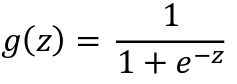

Ésto permite interpretar los números devueltos como probabilidades, y también nos permitirá saber si un caso se "activa" o no, de la siguiente forma:
- y = 1 si `sigmoid(z) >= 0.5`
- y = 1 si `sigmoid(z) < 0.5`



In [9]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

#### Función de coste
Para nuestra función de coste, necesitamos el siguiente comportamiento:
- y=1, h=1: No hay error
- y=0, h=1: Error máximo
- y=1, h=0: Error máximo
- y=0, h=0: No hay error

Básicamente, si nuestro modelo acierta, queremos coste 0, y si falla, queremos coste máximo.

Haciendo uso de algunos cambios en la función de "Entropía cruzada", podemos obtener una función con el comportamiento deseado:

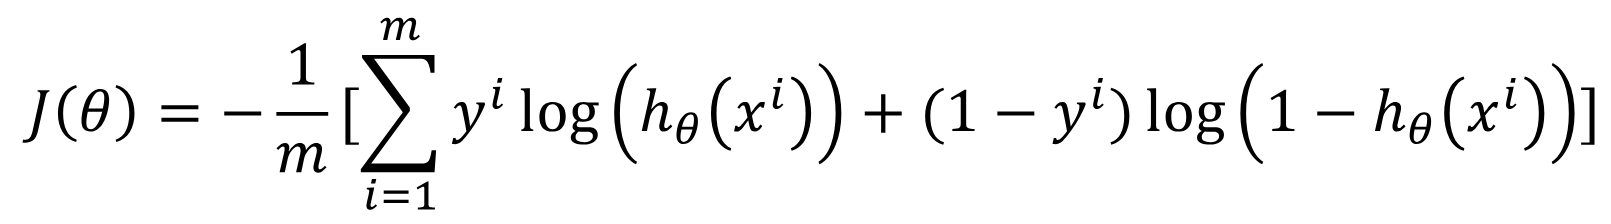

In [10]:
def cost(theta, X, y):
    m = len(y)
    h = sigmoid(np.dot(X, theta))
    return (-1/m)*np.sum((y * np.log(h)) + ((1-y) * np.log(1-h)))

#### Descenso de gradiente
Para optimizar los zetas, vamos a utilizar la función de descenso de gradiente:

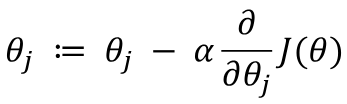

Que teniendo en cuenta la definición de la función anterior, se nos quedaría:

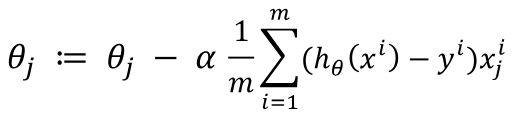

In [11]:
def gradientDescent(theta, X, y):
    h = sigmoid(np.dot(X, theta))
    return (1/m)*np.dot(X.T,(h-y))

### Entrenamiento

Ahora que ya tenemos todas las funciones implementadas, tenemos que entrenar el modelo haciendo uso de las mismas.

Primero, vamos a dividir el dataset en datos de entrenamiento y datos de prueba (*test*). En concreto, usaremos el 70% del dataset para entrenamiento y el 30% para test. Tambien subdividiremos los datos de entrenamiento en un conjunto de entrenamiento y uno de validación, con el mismo ratio 70-30.

In [12]:
trainingData = data.iloc[:int(len(data) * 0.7)]
testData = data.iloc[int(len(data) * 0.7):]
X_train



NameError: name 'X_train' is not defined

Ahora, vamos a repartir los datos de entrenamiento en una "*X*" y una "*y*",  

In [ ]:
def train(X, y, numIterations):
    rows, columns = X.shape
    
    # Usaremos la función op.fmin_cg para optimizar.
    # El zeta inicial será una fila de ceros.
    theta = op.fmin_cg(
        maxiter = numIterations, 
        f = cost, 
        x0 = np.zeros(columns).flatten(),
        fprime = gradientFunction,
        # Argumentos que toma nuest
        args = (X, y.to_numpy().flatten())
    )
    

In [ ]:
print(datos.shape)